# Twitter & Text Analytics Demo

In [1458]:
import re
import nltk
import string
import gensim
import operator
import matplotlib
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora, models
from collections import OrderedDict
from cassandra.cluster import Cluster
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from gensim.models.tfidfmodel import TfidfModel
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.cluster import KMeansClusterer, GAAClusterer, cosine_distance
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
sns.set_style('whitegrid')
matplotlib.style.use('ggplot')

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Nx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1459]:
def to_TF(tweets):
    import pandas as pd
    import nltk
    tweets = [w for l in tweets for w in l]

    ## Compute the frequency distribution of the words as a dictionary
    fdist = nltk.FreqDist(tweets) 
    ## Convert the dictionary to a dataframe contaning the words and
    ## counts indexed by the words, and then take the transpose.
    count_frame = pd.DataFrame(fdist, index =[0]).T
    count_frame.columns = ['Count']
    return(count_frame.sort_values('Count', ascending = False))

In [1460]:
def wf_bar(wf):
    import matplotlib.pyplot as plt
    ## Barplot of the most fequent words.   
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca()
    ax.invert_yaxis()
    wf['Count'][:30].plot(kind = 'barh', ax = ax)
    ax.set_title('Frequency of the most common words')
    ax.set_ylabel('Word')
    ax.set_xlabel('Frequency of word')
    ax.invert_yaxis()
    plt.show()
    return 'Done'

# Query de data zoals gewenst en op grote scaal

In [1461]:
cluster = Cluster(['localhost'], port=32769)
session = cluster.connect('twitter')

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  """Entry point for launching an IPython kernel.


In [1462]:
query = 'SELECT * FROM twitter.rawtweets'
df = pd.DataFrame(list(session.execute(query)))

# Verschoon de Twitter data

In [1463]:
ttb = str.maketrans({ch : None for ch in string.punctuation})
stop_dutch_words = stopwords.words('dutch')
stop_dutch_words.extend(['rt'])

In [1464]:
df.tweet = df.tweet.str.lower()
df.tweet = df.tweet.str.translate(ttb)

tknzr = TweetTokenizer()
df['tweettokens'] = df.tweet.apply(lambda tw : tknzr.tokenize(tw))

df['stoptweets'] = df.tweettokens.apply(lambda tw: [w for w in tw if ((w.lower() not in stop_dutch_words) 
                                                                      and (len(w) > 1) 
                                                                      and ('http' not in w.lower())
                                                                      and ('we' not in w.lower())
                                                                      and ('wij' not in w.lower())
                                                                      and ('on' not in w.lower())
                                                                      and ('jij' not in w.lower())
                                                                      and ('my' not in w.lower())
                                                                      and ('via' not in w.lower())
                                                                      and ('this' not in w.lower())
                                                                      and ('for' not in w.lower()))])

stemmer = SnowballStemmer("dutch")
df['cleantweets'] = df.stoptweets.apply(lambda tw: [stemmer.stem(w) for w in tw])

# Visualiseer de Twitter & Text Data

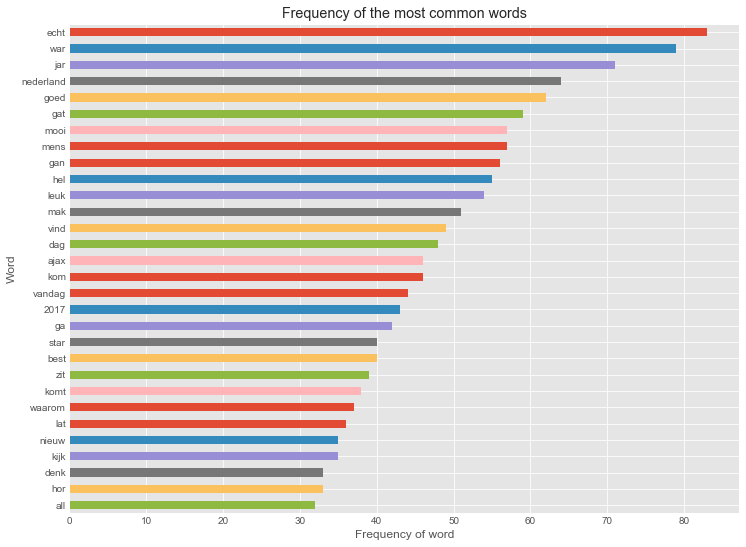

'Done'

In [1466]:
 wf_bar(to_TF(df.cleantweets))

# Analyseer en Classificeer de Tweets
We proberen automatisch de onderwerpen van de Tweets te herleiden en tweets te classificeren per onderwerp.

In [1468]:
def process_text(text, stem=False):
    """ Tokenize text and stem words removing punctuation """
    sp = {ch : None for ch in string.punctuation}
    ttb = str.maketrans(sp)
    text = text.translate(ttb)
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(text)
 
    if stem:
        stemmer = SnowballStemmer("dutch")
        tokens = [stemmer.stem(t) for t in tokens if len(t) > 1]
 
    return tokens

In [1469]:
 def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    tw_stopwords = stopwords.words('dutch')
    tw_stopwords.extend(['rt'])
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('dutch'),
                                 strip_accents='unicode',
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
#     cl_model = KMeans(init='k-means++', n_clusters=clusters, n_jobs=-1)
    cl_model = SpectralClustering(n_clusters=clusters, n_jobs=-1)
    cl_model.fit(tfidf_model)
    tw_clusters = cl_model.fit_predict(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(cl_model.labels_):
        clustering[label].append(idx)
 
    return (clustering, tw_clusters)

In [1470]:
(clusters, tw_clusters) = cluster_texts(df.loc[:,'tweet'], 7)
# pprint.pprint(dict(clusters))
# clusters
for idx in range(1,10):
    print(tw_clusters[idx], df.loc[idx,'tweet'])

0 rt dkyona weten we al waar die oorbellen anouk vandaan komen tvoh dtv 😍
2 falloutboy btstwt sisijswnajnsnw this is amazing
2 arbeiten  oldenburg alexandersfeld httpstcojwfwhtlquc
2 rtl7darts we zitten er klaar voor httpstcoqda1oiv6qt
2 nu lijkt gordongaattrouwen net op widm met al die hints over de vlinder lol
0 rt fdnieuws winnaar van de fdgazellen oryx de prijs voor de indrukwekkendste groeiprestatie is messagebird… 
2 iamestellejanse gewerkt ja
2 jpaternotte man maak je toch niet zo druk
2 wil je op een laagdrempelige manier met brugklassers in gesprek over verliefd zijn pesten en sexting gebruik dan… httpstcoxgvcbcii1z


In [1471]:
dictionary = corpora.Dictionary(df.stoptweets.tolist())
corpus = [dictionary.doc2bow(tw) for tw in df.stoptweets.tolist()]

In [1472]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=80, id2word = dictionary, passes=20)

In [1473]:
pprint(ldamodel.print_topics(num_topics=80, num_words=3))

[(0, '0.021*"18" + 0.020*"zin" + 0.018*"jaar"'),
 (1, '0.027*"moeten" + 0.023*"mn" + 0.020*"gemaakt"'),
 (2, '0.052*"heel" + 0.037*"nee" + 0.024*"goede"'),
 (3, '0.017*"kerst" + 0.016*"verandering" + 0.016*"kom"'),
 (4, '0.031*"maakt" + 0.029*"wilde" + 0.025*"fvdemocratie"'),
 (5, '0.012*"to" + 0.012*"the" + 0.011*"snape"'),
 (6, '0.075*"leuk" + 0.074*"vind" + 0.070*"goed"'),
 (7, '0.028*"nos" + 0.020*"ging" + 0.020*"examen"'),
 (8, '0.042*"haha" + 0.033*"nieuws" + 0.032*"open"'),
 (9, '0.023*"zoek" + 0.020*"finale" + 0.019*"soundos"'),
 (10, '0.026*"beetje" + 0.016*"mede" + 0.015*"moeder"'),
 (11, '0.034*"lekker" + 0.017*"loop" + 0.016*"slot"'),
 (12, '0.104*"ajax" + 0.047*"echt" + 0.038*"graag"'),
 (13, '0.034*"doe" + 0.021*"leuke" + 0.020*"paar"'),
 (14, '0.037*"denk" + 0.032*"kijk" + 0.016*"alle"'),
 (15, '0.022*"steracteur" + 0.018*"kerstmarkt" + 0.017*"nederlandse"'),
 (16, '0.034*"doet" + 0.033*"even" + 0.018*"eindelijk"'),
 (17, '0.047*"alleen" + 0.030*"klopt" + 0.027*"kijken"'

In [1474]:
lda_corpus = ldamodel[corpus]

In [1475]:
lda_corpus[0], df.stoptweets[0]

([(53, 0.87656249999999958)],
 ['video',
  'toegevoegd',
  'youtubeafspeellijst',
  '23f4beyct',
  'angel',
  'alanis',
  'tube'])

In [1476]:
bow = dictionary.doc2bow(df.stoptweets[0])
print("get_document_topics", ldamodel.get_document_topics(bow))

get_document_topics [(53, 0.87656249999999958)]


In [1477]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
print(tfidf[corpus[0]])

[(0, 0.29217062390921394), (1, 0.3299233647922937), (2, 0.33831928824936935), (3, 0.435908707731573), (4, 0.34824955801614743), (5, 0.435908707731573), (6, 0.435908707731573)]


In [1478]:
clusterer = KMeansClusterer(7, cosine_distance) 
clusterer.cluster(corpus_vectors, True)
print(clusterer.classify(array([3, 3])))

NameError: name 'corpus_vectors' is not defined